In [ ]:
#Assignment 1

In [1]:
# Question:
'''
Using PCAcreate a face recognition system that gives access to only certain people.
To implement this,you can use LFW_peoples dataset provided in the scikit-learn library.
Given this subset of images, apply PA to obtain the corresponding eigen face for each class. 
You can additionally train a classifier for recognition purposes.
'''

'\nUsing PCAcreate a face recognition system that gives access to only certain people.\nTo implement this,you can use LFW_peoples dataset provided in the scikit-learn library.\nGiven this subset of images, apply PA to obtain the corresponding eigen face for each class. \nYou can additionally train a classifier for recognition purposes.\n'

In [2]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
  
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)

# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
from time import time
from sklearn.decomposition import PCA

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized').fit(X_train)
print ("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))

print ("variance ratio: ", pca.explained_variance_ratio_)

Extracting the top 150 eigenfaces from 966 faces
done in 0.359s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
variance ratio:  [0.19346525 0.15116838 0.07083686 0.05951796 0.05157493 0.02887153
 0.02514486 0.02176467 0.0201938  0.01902124 0.01682211 0.01580597
 0.01223363 0.01087937 0.01064452 0.00979653 0.00892398 0.00854845
 0.00835711 0.00722636 0.00696569 0.00653856 0.00639558 0.00561317
 0.00531107 0.00520152 0.00507466 0.00484209 0.00443588 0.0041783
 0.00393705 0.00381728 0.00356061 0.00351201 0.00334556 0.0032993
 0.00314626 0.00296217 0.00290136 0.00284723 0.00280004 0.00267555
 0.00259901 0.00258401 0.00240919 0.00238994 0.00235403 0.00222587
 0.00217507 0.00216566 0.00209064 0.00205426 0.00200421 0.00197395
 0.0019383  0.00188764 0.00180173 0.00178897 0.00174819 0.00173054
 0.00165647 0.00162948 0.00157409 0.00153429 0.00149965 0.00147262
 0.00143931 0.00141882 0.00139698 0.00138147 0.00134005 0.00133169
 0.00128812 0.00125595 0.00124248 0.0012

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Train a SVM classification model

print ("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)

Fitting the classifier to the training set
done in 34.169s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print( "Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
done in 0.054s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.85       322
        macro avg       0.90      0.73      0.79       322
     weighted avg       0.87      0.85      0.85       322

[[  7   1   0   5   0   0   0]
 [  1  52   0   7   0   0   0]
 [  1   2  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   4   1   7   0]
 [  0   1   1   5   0   0  29]]


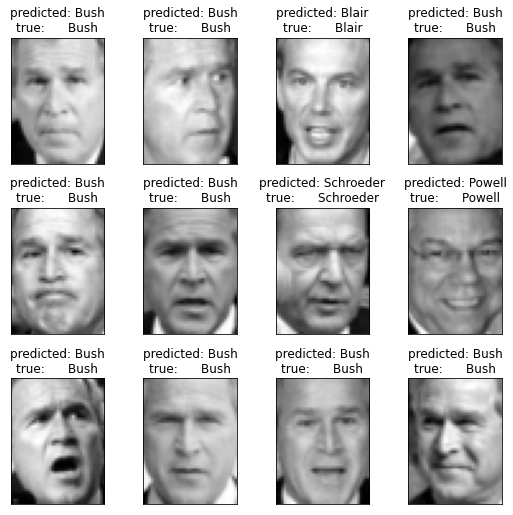

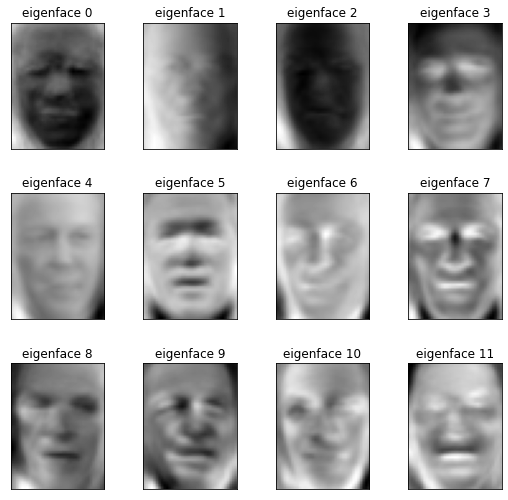

In [6]:
import pylab as pl

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()